# Experiment A.ii: Cross-worm Predictions with SHRED

Data obtained from Global Brain Dynamics Embed the Motor Command Sequence of Caenorhabditis elegans. Cell, 163(3), 656–669. http://doi.org/10.1016/j.cell.2015.09.034

SHRED (SHallow REcurrent Decoder) models are a network architecture that merges a recurrent layer (LSTM) with a shallow decoder network (SDN) to reconstruct high-dimensional spatio-temporal fields from a trajectory of sensor measurements of the field. More formally, the SHRED architecture can be written as
$$ \mathcal {H} \left( \{ y_i \} _{i=t-k}^t \right) = \mathcal {F} \left( \mathcal {G} \left( \{ y_i \} _{i=t-k}^t \right) ; W_{RN}) ; W_{SD} \right)$$
where $\mathcal F$ is a feed forward network parameterized by weights $W_{SD}$, $\mathcal G$ is a LSTM network parameterized by weights $W_{RN}$, and $\{ y_i \} _{i=t-k}^t$ is a trajectory of sensor measurements of a high-dimensional spatio-temporal field $\{ x_i \} _{i=t-k}^t$.

**Experiment A.ii: Extrapolating between worms**
- first three worms = training, 4th = validation, 5th = test
- randomly pick 3 neurons from group with high variance


In [2]:
# Importing all dependencies 
import numpy as np
import numpy as np
import torch
import subprocess
import os
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import random
import mne
from scipy.signal import butter, filtfilt
from scipy.signal import welch
from scipy.interpolate import CubicSpline
from scipy.io import loadmat
from sklearn.linear_model import Ridge


In [4]:
#Importing packages

# Change into the directory
os.chdir("/home/amy/SHRED_neuro/sindy-shred") ## Change to where the repo was cloned

from processdata import load_data
from processdata import TimeSeriesDataset
import sindy
import pysindy as ps
from pysindy.differentiation import FiniteDifference

os.environ["CUDA_VISIBLE_DEVICES"]="0"


# Loading the Data
- 5 worms
- 18 mins at roughly 2.85 samples per second --> ~3000 samples per trial
- 107 - 131 neurons

In [5]:
# Loading the Dataset
os.chdir("../")

data_path = 'worms/worm_data/WT_Stim.mat'
data = loadmat(data_path)
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'AVA_HisCl', 'WT_NoStim', 'WT_Stim'])


In [6]:
# Working with the no stim condition -- WORM ONE
neuron = 0
no_stim = data['WT_NoStim']
neuron_data = no_stim[0][neuron][0] #3137 timepoints, 109 neurons 
print(neuron_data.shape)
time = no_stim[0][neuron][4]
dt = time[1][0] - time[0][0]

m = neuron_data.shape[0] # number of timepoints
n = neuron_data.shape[1] #number of neurons 

neuron_data_cor = no_stim[0][neuron][1]

neuron_name = []
for i in range((n-1)):
    neuron_name.append(no_stim[0][neuron][3][0][i][0])

sr = no_stim[0][neuron][6][0][0]
# Movement Classifications;  
# ‘FWD’ forward crawling ‘SLOW’ forward slowing ‘DT’ dorsal post reversal turn ‘VT’ ventral post reversal turn 
# ‘REV1’ reverse crawling ‘REV2’ reverse crawling ‘REVSUS’ sustained reverse crawling ‘NOSTATE’ - ambiguous
FWD = no_stim[0][neuron][7][0][0][0]
SLOW = no_stim[0][neuron][7][0][0][1]
DT = no_stim[0][neuron][7][0][0][2]
VT = no_stim[0][neuron][7][0][0][3]
REV1 = no_stim[0][neuron][7][0][0][4]
REV2 = no_stim[0][neuron][7][0][0][5]
REVSUS = no_stim[0][neuron][7][0][0][6]
NOSTATE = no_stim[0][neuron][7][0][0][7]

print('number timepoints(m)', m, 'number neurons(n):', n)
print('dt', dt)
print('sr', sr, 'Hz')



neuron_one = neuron_data_cor[:1000,:]
time_one = time[:1000].flatten()
neuron_name_one = np.array(neuron_name)


(3137, 109)
number timepoints(m) 3137 number neurons(n): 109
dt 0.34427797258527254
sr 2.9046296296296297 Hz


In [8]:
# Working with the no stim condition -- WORM TWO
neuron = 1
no_stim = data['WT_NoStim']
neuron_data = no_stim[0][neuron][0] #3137 timepoints, 109 neurons 
time = no_stim[0][neuron][4]
dt = time[1][0] - time[0][0]

m = neuron_data.shape[0] # number of timepoints
n = neuron_data.shape[1] #number of neurons 

neuron_data_cor = no_stim[0][neuron][1]

neuron_name = []
for i in range((n-1)):
    neuron_name.append(no_stim[0][neuron][3][0][i][0])
sr = no_stim[0][neuron][6][0][0]
# Movement Classifications;  
# ‘FWD’ forward crawling ‘SLOW’ forward slowing ‘DT’ dorsal post reversal turn ‘VT’ ventral post reversal turn 
# ‘REV1’ reverse crawling ‘REV2’ reverse crawling ‘REVSUS’ sustained reverse crawling ‘NOSTATE’ - ambiguous
FWD = no_stim[0][neuron][7][0][0][0]
SLOW = no_stim[0][neuron][7][0][0][1]
DT = no_stim[0][neuron][7][0][0][2]
VT = no_stim[0][neuron][7][0][0][3]
REV1 = no_stim[0][neuron][7][0][0][4]
REV2 = no_stim[0][neuron][7][0][0][5]
REVSUS = no_stim[0][neuron][7][0][0][6]
NOSTATE = no_stim[0][neuron][7][0][0][7]

print('number timepoints(m)', m, 'number neurons(n):', n)
print('dt', dt)
print('sr', sr, 'Hz')


neuron_two = neuron_data_cor[:1000,:]
time_two = time[:1000].flatten() + np.ones(1000)*time_one[-1]
neuron_name_two = np.array(neuron_name)



number timepoints(m) 3134 number neurons(n): 135
dt 0.3446075303126994
sr 2.901851851851852 Hz


In [9]:
# Working with the no stim condition -- WORM THREE
neuron = 2
no_stim = data['WT_NoStim']
neuron_data = no_stim[0][neuron][0] #3137 timepoints, 109 neurons 
time = no_stim[0][neuron][4]
dt = (dt+ time[1][0] - time[0][0])/2

m = neuron_data.shape[0] # number of timepoints
n = neuron_data.shape[1] #number of neurons 

neuron_data_cor = no_stim[0][neuron][1]

neuron_name = []
for i in range((n-1)):
    neuron_name.append(no_stim[0][neuron][3][0][i][0])

sr = (sr + no_stim[0][neuron][6][0][0])/2
# Movement Classifications;  
# ‘FWD’ forward crawling ‘SLOW’ forward slowing ‘DT’ dorsal post reversal turn ‘VT’ ventral post reversal turn 
# ‘REV1’ reverse crawling ‘REV2’ reverse crawling ‘REVSUS’ sustained reverse crawling ‘NOSTATE’ - ambiguous
FWD = no_stim[0][neuron][7][0][0][0]
SLOW = no_stim[0][neuron][7][0][0][1]
DT = no_stim[0][neuron][7][0][0][2]
VT = no_stim[0][neuron][7][0][0][3]
REV1 = no_stim[0][neuron][7][0][0][4]
REV2 = no_stim[0][neuron][7][0][0][5]
REVSUS = no_stim[0][neuron][7][0][0][6]
NOSTATE = no_stim[0][neuron][7][0][0][7]

print('number timepoints(m)', m, 'number neurons(n):', n)
print('dt', dt)
print('sr', sr, 'Hz')



neuron_three = neuron_data_cor[:1000,:]
time_three = time[:1000].flatten()+ np.ones(1000)*time_two[-1]
neuron_name_three = np.array(neuron_name)




number timepoints(m) 3059 number neurons(n): 131
dt 0.34883204237112575
sr 2.8671296296296296 Hz


In [10]:
# Working with the no stim condition -- WORM FOUR
neuron = 3
no_stim = data['WT_NoStim']
neuron_data = no_stim[0][neuron][0] #3137 timepoints, 109 neurons 
time = no_stim[0][neuron][4]
dt = (dt+ time[1][0] - time[0][0])/2

m = neuron_data.shape[0] # number of timepoints
n = neuron_data.shape[1] #number of neurons 

neuron_data_cor = no_stim[0][neuron][1]

neuron_name = []
for i in range((n-1)):
    neuron_name.append(no_stim[0][neuron][3][0][i][0])

sr = (sr + no_stim[0][neuron][6][0][0])/2
# Movement Classifications;  
# ‘FWD’ forward crawling ‘SLOW’ forward slowing ‘DT’ dorsal post reversal turn ‘VT’ ventral post reversal turn 
# ‘REV1’ reverse crawling ‘REV2’ reverse crawling ‘REVSUS’ sustained reverse crawling ‘NOSTATE’ - ambiguous
FWD = no_stim[0][neuron][7][0][0][0]
SLOW = no_stim[0][neuron][7][0][0][1]
DT = no_stim[0][neuron][7][0][0][2]
VT = no_stim[0][neuron][7][0][0][3]
REV1 = no_stim[0][neuron][7][0][0][4]
REV2 = no_stim[0][neuron][7][0][0][5]
REVSUS = no_stim[0][neuron][7][0][0][6]
NOSTATE = no_stim[0][neuron][7][0][0][7]

print('number timepoints(m)', m, 'number neurons(n):', n)
print('dt', dt)
print('sr', sr, 'Hz')



neuron_four = neuron_data_cor[:1000,:]
time_four = time[:1000].flatten() + np.ones(1000)*time_three[-1]
neuron_name_four = np.array(neuron_name)



number timepoints(m) 3311 number neurons(n): 125
dt 0.33750874241781903
sr 2.966435185185185 Hz


In [11]:
# Working with the no stim condition -- WORM FIVE
neuron = 4
no_stim = data['WT_NoStim']
neuron_data = no_stim[0][neuron][0] #3137 timepoints, 109 neurons 
time = no_stim[0][neuron][4]
dt = (dt+ time[1][0] - time[0][0])/2

m = neuron_data.shape[0] # number of timepoints
n = neuron_data.shape[1] #number of neurons 

neuron_data_cor = no_stim[0][neuron][1]

neuron_name = []
for i in range((n-1)):
    neuron_name.append(no_stim[0][neuron][3][0][i][0])

sr = (sr + no_stim[0][neuron][6][0][0])/2
# Movement Classifications;  
# ‘FWD’ forward crawling ‘SLOW’ forward slowing ‘DT’ dorsal post reversal turn ‘VT’ ventral post reversal turn 
# ‘REV1’ reverse crawling ‘REV2’ reverse crawling ‘REVSUS’ sustained reverse crawling ‘NOSTATE’ - ambiguous
FWD = no_stim[0][neuron][7][0][0][0]
SLOW = no_stim[0][neuron][7][0][0][1]
DT = no_stim[0][neuron][7][0][0][2]
VT = no_stim[0][neuron][7][0][0][3]
REV1 = no_stim[0][neuron][7][0][0][4]
REV2 = no_stim[0][neuron][7][0][0][5]
REVSUS = no_stim[0][neuron][7][0][0][6]
NOSTATE = no_stim[0][neuron][7][0][0][7]

print('number timepoints(m)', m, 'number neurons(n):', n)
print('dt', dt)
print('sr', sr, 'Hz')



neuron_five = neuron_data_cor[:1000,:]
time_five = time[:1000].flatten() + np.ones(1000)*time_four[-1]
neuron_name_five = np.array(neuron_name)


number timepoints(m) 3021 number neurons(n): 129
dt 0.3475031298980853
sr 2.881828703703704 Hz


In [14]:
#### Finding the neurons recorded from across all five worms 

common_values = np.intersect1d(neuron_name_one, neuron_name_two)
common_values = np.intersect1d(common_values, neuron_name_three)
common_values = np.intersect1d(common_values, neuron_name_four)
common_values = np.intersect1d(common_values, neuron_name_five)
print('common neurons', common_values)

#neuron one
indices = [np.where(neuron_name_one == q)[0] for q in common_values]
neuron_1 = np.squeeze(neuron_one[:,indices])

#neuron two
indices = [np.where(neuron_name_two == q)[0] for q in common_values]
neuron_2 = np.squeeze(neuron_two[:,indices])

#neuron three
indices = [np.where(neuron_name_three == q)[0] for q in common_values]
neuron_3 = np.squeeze(neuron_three[:,indices])

#neuron four
indices = [np.where(neuron_name_four == q)[0] for q in common_values]
neuron_4 = np.squeeze(neuron_four[:,indices])

#neuron five
indices = [np.where(neuron_name_five == q)[0] for q in common_values]
neuron_5 = np.squeeze(neuron_five[:,indices])



common neurons ['1' '10' '103' '105' '11' '12' '14' '18' '2' '20' '28' '3' '4' '47' '5'
 '50' '6' '7' '8' '86' '9' '92' '94' '99' 'AIBL' 'AIBR' 'ALA' 'ASKR'
 'AVAL' 'AVAR' 'AVBL' 'AVBR' 'AVEL' 'AVER' 'RIBL' 'RID' 'RIML' 'RIMR'
 'RIVL' 'RIVR' 'RMED' 'RMEL' 'RMER' 'SMDVR' 'VB02']


(5000, 45)
45 5000


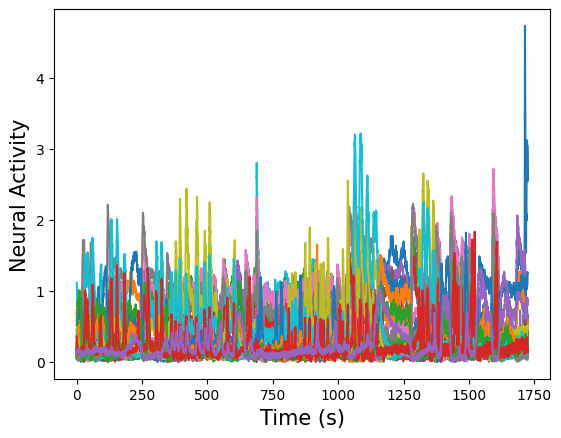

In [15]:
load_X = np.vstack((neuron_1, neuron_2, neuron_3, neuron_4, neuron_5))
time = np.hstack((time_one, time_two, time_three, time_four, time_five))
print(load_X.shape)

n_s = load_X.shape[1]
n_t = load_X.shape[0]
print(n_s, n_t)
plt.plot(time, load_X)
plt.xlabel('Time (s)', fontsize = 15)
plt.ylabel('Neural Activity', fontsize = 15)
plt.show()

Preparing the data 

Studying the variance of the neuronal activity

(5000, 45)
0.2254347350856019


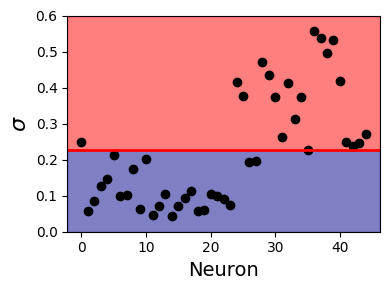

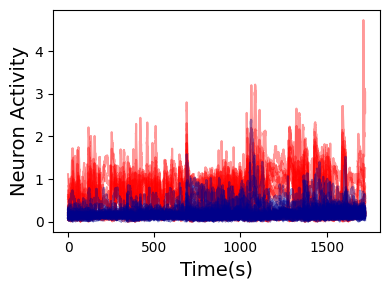

In [16]:
# Splitting into high and low variance groups
var = np.std(load_X, axis = 0)
print(load_X.shape)
var_ave = np.mean(var)
print(var_ave)
neuron_index = np.arange(var.shape[0])

#plotting the distribution of std 
plt.figure(figsize = (4,3))
plt.axhspan(0, var_ave, color='darkblue', alpha=0.5)
plt.axhspan(var_ave,0.6 ,color='red', alpha=0.5)
plt.scatter(neuron_index, var, color = 'black', label = '$\sigma$')
plt.axhline(var_ave, color = 'red', linewidth = 2)
plt.xlabel('Neuron', fontsize = 14)
plt.ylabel('$\sigma$', fontsize = 16)
plt.ylim((0,0.6))
plt.tight_layout()
plt.savefig("/home/amy/SHRED_neuro/worms/data_output/figs/std_scatter.png", transparent=True, dpi=500)
plt.show()


# Finding indices for high variance cases
high_ind = np.where(var > var_ave)[0]
low_ind = np.where(var < var_ave)[0]
plt.figure(figsize = (4,3))
plt.plot(time, load_X[:,high_ind], color = 'red', alpha = 0.4)
plt.plot(time, load_X[:,low_ind], color = 'darkblue', alpha = 0.4)
plt.xlabel('Time(s)', fontsize = 14)
plt.ylabel('Neuron Activity', fontsize = 14)
plt.tight_layout()
plt.savefig("/home/amy/SHRED_neuro/worms/data_output/figs/var_traces.svg", transparent=True, dpi=250)
plt.show()



**Select 3 randomly from high variance**

Text(0, 0.5, 'Neurons')

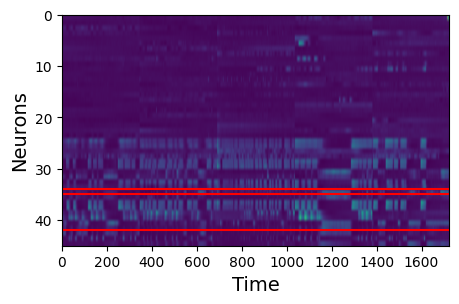

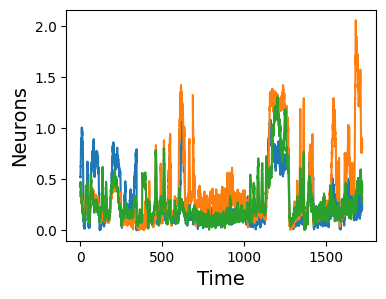

In [17]:
num_neurons = 3 
lags = 200

# Randomly select the neurons to train the SHRED model on
indices = np.random.choice(high_ind.shape[0], size= num_neurons, replace=False) 
neuron_locations = high_ind[indices]

#Plotting the Carpet plot
plt.figure(figsize = (5,3))
plt.imshow(load_X.T, aspect = 'auto', extent=[time[0], time[-1], n_s,0])

plt.xlabel('Time', fontsize = 14)
plt.ylabel('Neurons',fontsize = 14)

for i in range(neuron_locations.shape[0]):
  plt.axhline(neuron_locations[i], color = 'red')


plt.figure(figsize = (4,3))
plt.plot(time, load_X[:,neuron_locations])
plt.xlabel('Time', fontsize = 14)
plt.ylabel('Neurons', fontsize = 14)




In [18]:
test_val_size = 2000 
train_indices = np.arange(0, n_t - lags - test_val_size)
mask = np.ones(n_t - lags)
mask[train_indices] = 0
valid_test_indices = np.arange(0, n_t - lags)[np.where(mask!=0)[0]]
valid_indices = valid_test_indices[lags:1000]
test_indices = valid_test_indices[1000+lags:2000]


In [20]:
print('val index', valid_indices)

val index [3000 3001 3002 3003 3004 3005 3006 3007 3008 3009 3010 3011 3012 3013
 3014 3015 3016 3017 3018 3019 3020 3021 3022 3023 3024 3025 3026 3027
 3028 3029 3030 3031 3032 3033 3034 3035 3036 3037 3038 3039 3040 3041
 3042 3043 3044 3045 3046 3047 3048 3049 3050 3051 3052 3053 3054 3055
 3056 3057 3058 3059 3060 3061 3062 3063 3064 3065 3066 3067 3068 3069
 3070 3071 3072 3073 3074 3075 3076 3077 3078 3079 3080 3081 3082 3083
 3084 3085 3086 3087 3088 3089 3090 3091 3092 3093 3094 3095 3096 3097
 3098 3099 3100 3101 3102 3103 3104 3105 3106 3107 3108 3109 3110 3111
 3112 3113 3114 3115 3116 3117 3118 3119 3120 3121 3122 3123 3124 3125
 3126 3127 3128 3129 3130 3131 3132 3133 3134 3135 3136 3137 3138 3139
 3140 3141 3142 3143 3144 3145 3146 3147 3148 3149 3150 3151 3152 3153
 3154 3155 3156 3157 3158 3159 3160 3161 3162 3163 3164 3165 3166 3167
 3168 3169 3170 3171 3172 3173 3174 3175 3176 3177 3178 3179 3180 3181
 3182 3183 3184 3185 3186 3187 3188 3189 3190 3191 3192 3193 3194 3

In [21]:
print('test index', test_indices)

test index [4000 4001 4002 4003 4004 4005 4006 4007 4008 4009 4010 4011 4012 4013
 4014 4015 4016 4017 4018 4019 4020 4021 4022 4023 4024 4025 4026 4027
 4028 4029 4030 4031 4032 4033 4034 4035 4036 4037 4038 4039 4040 4041
 4042 4043 4044 4045 4046 4047 4048 4049 4050 4051 4052 4053 4054 4055
 4056 4057 4058 4059 4060 4061 4062 4063 4064 4065 4066 4067 4068 4069
 4070 4071 4072 4073 4074 4075 4076 4077 4078 4079 4080 4081 4082 4083
 4084 4085 4086 4087 4088 4089 4090 4091 4092 4093 4094 4095 4096 4097
 4098 4099 4100 4101 4102 4103 4104 4105 4106 4107 4108 4109 4110 4111
 4112 4113 4114 4115 4116 4117 4118 4119 4120 4121 4122 4123 4124 4125
 4126 4127 4128 4129 4130 4131 4132 4133 4134 4135 4136 4137 4138 4139
 4140 4141 4142 4143 4144 4145 4146 4147 4148 4149 4150 4151 4152 4153
 4154 4155 4156 4157 4158 4159 4160 4161 4162 4163 4164 4165 4166 4167
 4168 4169 4170 4171 4172 4173 4174 4175 4176 4177 4178 4179 4180 4181
 4182 4183 4184 4185 4186 4187 4188 4189 4190 4191 4192 4193 4194 

In [ ]:
latent_dim = 64
poly_order = 1
include_sine = False
library_dim = sindy.library_size(latent_dim, poly_order, include_sine, True)
os.chdir("/home/amy/SHRED_neuro/sindy-shred")
import sindy_shred



## high variance
for k in range(5): #Dictates number of trials to run
    # Randomly select the neurons to train the SHRED model on
    indices = np.random.choice(high_ind.shape[0], size= num_neurons, replace=False) 
    neuron_locations = high_ind[indices]
    file_path = f"/home/amy/SHRED_neuro/worms/data_output/exp_Aii/neuron_loc_{k}.npy"
    np.save(file_path, neuron_locations)
    sc = MinMaxScaler()
    sc = sc.fit(load_X[train_indices])
    transformed_X = sc.transform(load_X)

    ### Generate input sequences to a SHRED model
    all_data_in = np.zeros((n_t - lags, lags, num_neurons))
    for i in range(len(all_data_in)):
        all_data_in[i] = transformed_X[i:i+lags, neuron_locations]

    ### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

    ### -1 to have output be at the same time as final sensor measurements
    train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

    shred = sindy_shred.SINDy_SHRED(num_neurons, n_s, hidden_size=latent_dim, hidden_layers=2, l1=350, l2=400, dropout=0.1,
                                    library_dim=library_dim, poly_order=poly_order,
                                    include_sine=include_sine, dt=dt, layer_norm=False).to(device)

    validation_errors = sindy_shred.fit(shred, train_dataset, valid_dataset, batch_size=128, num_epochs=200,
                                        lr=1e-3, verbose=True, threshold=0.25, patience=5, sindy_regularization=10.0,
                                        optimizer="AdamW", thres_epoch=100)
    
    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    mse_test = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
    print('mse test', mse_test)
    train_recons = sc.inverse_transform(shred(train_dataset.X).detach().cpu().numpy())
    train_ground_truth = sc.inverse_transform(train_dataset.Y.detach().cpu().numpy())
    mse_train = np.linalg.norm(train_recons - train_ground_truth) / np.linalg.norm(train_ground_truth)
    print('mse train', mse_train)

    file_path = f"/home/amy/SHRED_neuro/worms/data_output/exp_Aii/train_recon_{k}.npy"
    np.save(file_path, train_recons)

    file_path = f"/home/amy/SHRED_neuro/worms/data_output/exp_Aii/test_recon_{k}.npy"
    np.save(file_path, test_recons)


    file_path = f"/home/amy/SHRED_neuro/worms/data_output/exp_Aii/train_gt_{k}.npy"
    np.save(file_path, train_ground_truth)

    file_path = f"/home/amy/SHRED_neuro/worms/data_output/exp_Aii/test_gt_{k}.npy"
    np.save(file_path, test_ground_truth)

1 : tensor(0.0457, device='cuda:0', grad_fn=<AddBackward0>)
2 : tensor(0.0376, device='cuda:0', grad_fn=<AddBackward0>)
3 : tensor(0.0346, device='cuda:0', grad_fn=<AddBackward0>)
4 : tensor(0.0344, device='cuda:0', grad_fn=<AddBackward0>)
5 : tensor(0.0334, device='cuda:0', grad_fn=<AddBackward0>)
6 : tensor(0.0326, device='cuda:0', grad_fn=<AddBackward0>)
7 : tensor(0.0333, device='cuda:0', grad_fn=<AddBackward0>)
8 : tensor(0.0331, device='cuda:0', grad_fn=<AddBackward0>)
9 : tensor(0.0335, device='cuda:0', grad_fn=<AddBackward0>)
10 : tensor(0.0332, device='cuda:0', grad_fn=<AddBackward0>)
11 : tensor(0.0332, device='cuda:0', grad_fn=<AddBackward0>)
12 : tensor(0.0331, device='cuda:0', grad_fn=<AddBackward0>)
13 : tensor(0.0334, device='cuda:0', grad_fn=<AddBackward0>)
14 : tensor(0.0336, device='cuda:0', grad_fn=<AddBackward0>)
15 : tensor(0.0328, device='cuda:0', grad_fn=<AddBackward0>)
16 : tensor(0.0319, device='cuda:0', grad_fn=<AddBackward0>)
17 : tensor(0.0320, device='cuda:

## Plotting the Data

(800, 45)
(45, 3600)


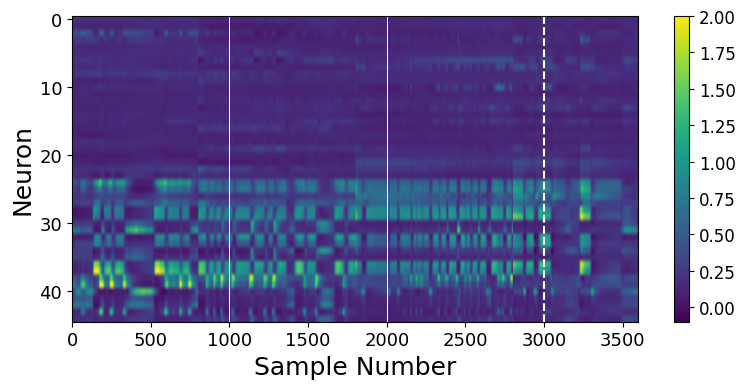

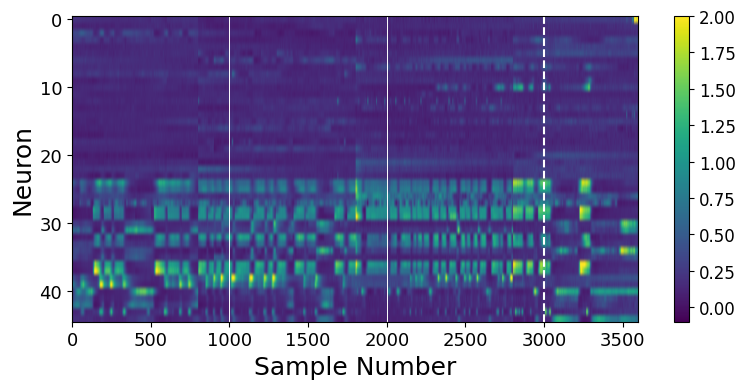

[0.1831911, 0.53521204]


In [ ]:
data = np.load("/home/amy/SHRED_neuro/worms/data_output/exp_Aii/train_recon_4.npy")
train_recons = data
data = np.load("/home/amy/SHRED_neuro/worms/data_output/exp_Aii/test_recon_4.npy")
test_recons = data

data = np.load("/home/amy/SHRED_neuro/worms/data_output/exp_Aii/train_gt_4.npy")
train_ground_truth = data
data = np.load("/home/amy/SHRED_neuro/worms/data_output/exp_Aii/test_gt_4.npy")
test_ground_truth= data

data_recons = np.hstack((train_recons.T, test_recons.T))
print(test_recons.shape)
print(data_recons.shape)
plt.figure(figsize = (8,4))
plt.imshow(data_recons, aspect = 'auto', vmin=-0.1, vmax=2)
plt.axvline(3000, color = 'white', linestyle = '--')
plt.axvline(1000, color = 'white', linewidth = 0.7)
plt.axvline(2000, color = 'white', linewidth = 0.7)
plt.tick_params(axis='both', which='major', labelsize=13)

plt.xlabel('Sample Number', fontsize = 18)
plt.ylabel('Neuron', fontsize = 18)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig("/home/amy/SHRED_neuro/worms/data_output/figs/exp3_recons.png", transparent=True, dpi=500)

plt.show()


data_gt = np.hstack((train_ground_truth.T, test_ground_truth.T))
plt.figure(figsize = (8,4))
plt.imshow(data_gt, aspect = 'auto', vmin=-0.1, vmax=2)
plt.axvline(3000, color = 'white', linestyle = '--')
plt.axvline(1000, color = 'white', linewidth = 0.7)
plt.axvline(2000, color = 'white', linewidth = 0.7)
plt.xlabel('Sample Number', fontsize = 18)
plt.ylabel('Neuron', fontsize = 18)
plt.tick_params(axis='both', which='major', labelsize=13)

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=12)

plt.tight_layout()
plt.savefig("/home/amy/SHRED_neuro/worms/data_output/figs/exp3_gt.png", transparent=True, dpi=500)
plt.show()


mse_train = np.linalg.norm(train_recons - train_ground_truth) / np.linalg.norm(train_ground_truth)
mse_test = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
print([mse_train, mse_test])